In [ ]:
from arch import arch_model
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
AAPL_data = pd.read_csv('data/AAPL.csv')
AAPL_data = AAPL_data.set_index('Date')

#인덱스를 datetime으로 변경
AAPL_data.index = pd.to_datetime(AAPL_data.index)
AAPL_data['log_price_return'] = np.log(AAPL_data['Adj Close']).diff(1) 
AAPL_data['squared_log_price_return'] = AAPL_data['log_price_return'] ** 2

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
volatility = AAPL_data['squared_log_price_return'].dropna().rolling(window=4).sum() / 5.0
normalzied_volatility = scaler.fit_transform(volatility.values.reshape(-1,1))


In [ ]:
import numpy as np
from scipy.optimize import differential_evolution, LinearConstraint
import arch

# GARCH(1,1) 모델의 로그 우도 함수 정의
def garch_log_likelihood(params, returns):
    omega, alpha, beta = params
    model = arch.arch_model(returns, vol='Garch',mean='Zero', p=1, q=1)
    results = model.fit(disp='off', show_warning=False, options={'maxiter': 1},
                        starting_values=np.array([omega, alpha, beta]))
    log_likelihood = results.loglikelihood
    return -log_likelihood

returns = AAPL_data['log_price_return'].dropna() * 100 #scaling 
train_data= returns[:2999,]

# 최적화 범위 설정
bounds = [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]
#조건 alpha + beta < 1
LC = LinearConstraint([[0,1,1]], lb=0, ub=1)

# DE 알고리즘을 사용한 파라미터 추정
result = differential_evolution(garch_log_likelihood, bounds=bounds, args=(train_data,), constraints=LC,
                                strategy='best1bin', maxiter=30, popsize=20, tol=1e-3, mutation=(0.3, 1),
                                recombination=0.7, seed=42)


print("Optimized GARCH(1,1) Parameters:")
print(result.x)


In [ ]:
optimal_params = result.x

In [ ]:
import datetime as dt

start = dt.datetime(2000,1,4)
end = dt.datetime(2013,11,29)
split_date = dt.datetime(2011,12,2)

index = returns.index
start_loc = 0
end_loc = np.where(index > split_date)[0].min()

AAPL_garch = arch_model(returns, vol='Garch', p=1, o = 0, q = 1, dist='Normal')

forecasts = {}
for i in range(500):
    res = AAPL_garch.fit(first_obs=i, last_obs=i + end_loc)
    temp = res.forecast(horizon=1).variance.dropna()
    fcast = temp.iloc[0]
    date = temp.iloc[1].name # 한칸 씩 예측하니깐
    forecasts[date] = fcast[0]

/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


,h.1
Date,
2000-01-04,NaN
2000-01-05,NaN
2000-01-06,NaN
2000-01-07,NaN
2000-01-10,NaN
...,...
2013-11-22,0.364969
2013-11-25,0.700418
2013-11-26,2.554208


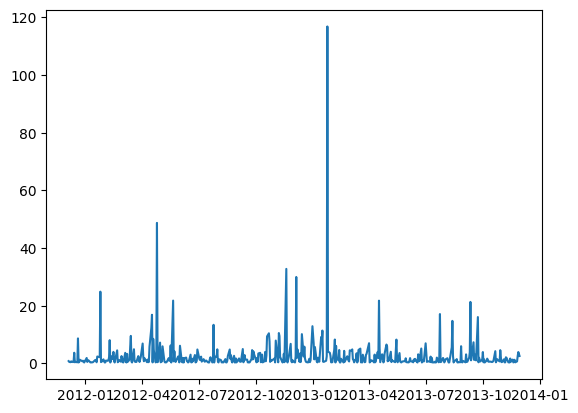

In [161]:
#train 까지 fit하고 나머지 예측

fixes = AAPL_garch.fix([0.0016,0.32,0.67])
forecasts = fixes.forecast(start = end_loc)
plt.plot(forecasts.variance)
forecasts.variance

,Forecast
2011-12-05,4.268986
2011-12-06,3.947533
2011-12-07,3.682848
2011-12-08,3.440466
2011-12-09,3.170901
...,...
2013-11-22,2.199679
2013-11-25,2.136237
2013-11-26,2.081161
2013-11-27,2.159037


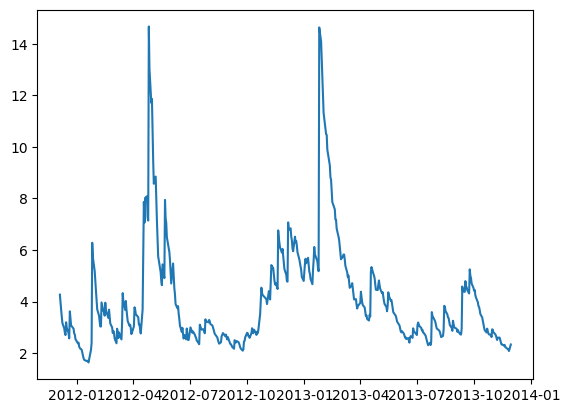

In [149]:
df = pd.DataFrame.from_dict(forecasts,orient='index', columns=['Forecast'])
df
plt.plot(df)

In [128]:
end_loc = np.where(index > split_date)[0]
returns.index[end_loc[0]]
len(end_loc)

Timestamp('2011-12-05 00:00:00')

500

In [152]:
df = pd.DataFrame.from_dict(forecasts,orient='index', columns=['Forecast'])


,Forecast
2011-12-05,4.268986
2011-12-06,3.947533
2011-12-07,3.682848
2011-12-08,3.440466
2011-12-09,3.170901
...,...
2013-11-22,2.199679
2013-11-25,2.136237
2013-11-26,2.081161
2013-11-27,2.159037


In [136]:
end_loc = np.where(index > split_date)[0].min()
res = AAPL_garch.fit(first_obs=0, last_obs=end_loc)
cond_dict = res.conditional_volatility.dropna()
cond_df = pd.DataFrame(cond_dict)
cond_df.columns = ['Forecast']
cond_df

Iteration:      1,   Func. Count:      6,   Neg. LLF: 17341.56047297718
Iteration:      2,   Func. Count:     14,   Neg. LLF: 3824062.9107967513
Iteration:      3,   Func. Count:     21,   Neg. LLF: 7604.132035733221
Iteration:      4,   Func. Count:     29,   Neg. LLF: 7239.510640000435
Iteration:      5,   Func. Count:     34,   Neg. LLF: 7245.1796938660245
Iteration:      6,   Func. Count:     40,   Neg. LLF: 7376.942127978036
Iteration:      7,   Func. Count:     48,   Neg. LLF: 7239.376187845643
Iteration:      8,   Func. Count:     53,   Neg. LLF: 7239.376074185087
Iteration:      9,   Func. Count:     58,   Neg. LLF: 7239.376044447115
Iteration:     10,   Func. Count:     62,   Neg. LLF: 7239.376044345185
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7239.376044447115
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10


,Forecast
Date,
2000-01-04,5.284718
2000-01-05,5.832195
2000-01-06,5.523860
2000-01-07,6.066966
2000-01-10,5.914323
...,...
2011-11-28,2.112751
2011-11-29,2.278565
2011-11-30,2.200120


In [137]:
df = pd.DataFrame.from_dict(forecasts,orient='index', columns=['Forecast'])

tmp = pd.concat([cond_df,df])

In [138]:
tmp

,Forecast
2000-01-04,5.284718
2000-01-05,5.832195
2000-01-06,5.523860
2000-01-07,6.066966
2000-01-10,5.914323
...,...
2013-11-21,2.199679
2013-11-22,2.136237
2013-11-25,2.081161
2013-11-26,2.159037


<Figure size 1000x600 with 0 Axes>

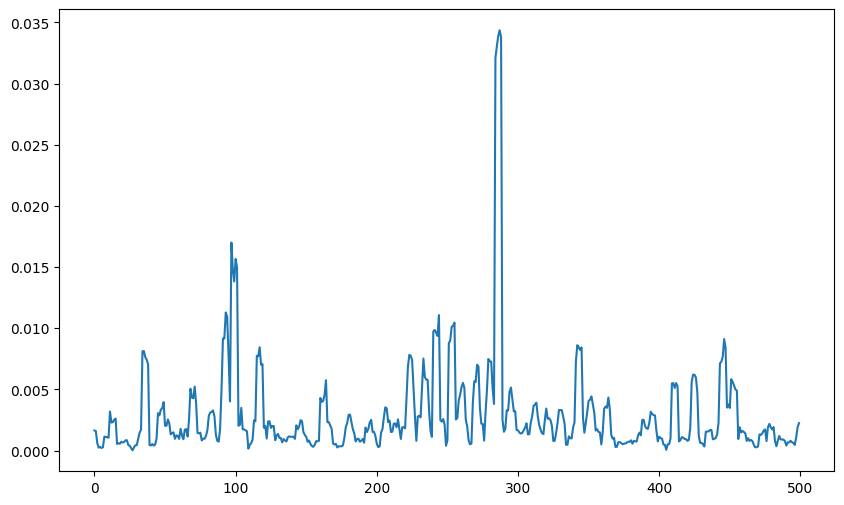

In [140]:
AAPL_data = pd.read_csv('data/AAPL.csv')
AAPL_data['log_price_return'] = np.log(AAPL_data['Adj Close']).diff(1)
AAPL_data['squared_log_price_return'] = AAPL_data['log_price_return'] ** 2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
#논문에서 명시된 realized volatility 
volatility = AAPL_data['squared_log_price_return'].dropna().rolling(window=5).sum() / 5.0

ret = AAPL_data['squared_log_price_return'].dropna() 

plt.figure(figsize=(10,6))
#volatility 정규화
scaler = MinMaxScaler()
normalzied_volatility = scaler.fit_transform(volatility.values.reshape(-1,1))
plt.plot(normalzied_volatility[2999:])
